In [41]:
import math
import numpy
import torch
import torchaudio
torchaudio.set_audio_backend("soundfile")
import matplotlib.pyplot as plt

In [42]:
loadedData = torchaudio.load("a_a_i_a_u_e_a.wav")
tensor = loadedData[0][0]
sampleRate = loadedData[1]
del loadedData

In [43]:
"""
transformedTensor = torch.stft(tensor, 8129, hop_length = 8129, win_length = 8129, return_complex = True)
backTransformedTensor = torch.istft(transformedTensor, 8129, hop_length = 8129, win_length = 8129, length = 1036800)
torchaudio.save("output.wav", backTransformedTensor, sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)
difference = backTransformedTensor - tensor
error = difference/tensor
error = error * torch.isfinite(error)
error = torch.nan_to_num(error)
Amplitudes = transformedTensor.abs()
Phases = transformedTensor.angle()
Element = Amplitudes[0].transpose(0,1)[40]
maximum = torch.max(Element, 0)
height = maximum.values.item()
center = maximum.indices.item()
"""

'\ntransformedTensor = torch.stft(tensor, 8129, hop_length = 8129, win_length = 8129, return_complex = True)\nbackTransformedTensor = torch.istft(transformedTensor, 8129, hop_length = 8129, win_length = 8129, length = 1036800)\ntorchaudio.save("output.wav", backTransformedTensor, sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)\ndifference = backTransformedTensor - tensor\nerror = difference/tensor\nerror = error * torch.isfinite(error)\nerror = torch.nan_to_num(error)\nAmplitudes = transformedTensor.abs()\nPhases = transformedTensor.angle()\nElement = Amplitudes[0].transpose(0,1)[40]\nmaximum = torch.max(Element, 0)\nheight = maximum.values.item()\ncenter = maximum.indices.item()\n'

In [44]:
pitchTensor = torchaudio.functional.detect_pitch_frequency(tensor, sampleRate, frame_time = 0.01, win_length = 10, freq_low = 85, freq_high = 1000)

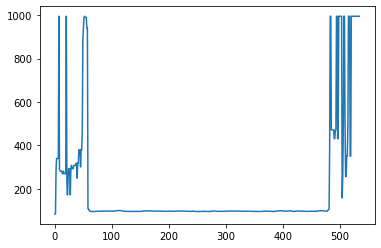

In [45]:
plt.plot(pitchTensor)

In [46]:
expectedPitch = pitchTensor[250]
searchRange = 0.2
batchSize = math.floor((1. + searchRange) * sampleRate / expectedPitch)
lowerSearchLimit = math.floor((1. - searchRange) * sampleRate / expectedPitch)

In [47]:
batchStart = 0
deltas = torch.tensor([], dtype = int)
while batchStart + batchSize <= tensor.size()[0]:
    
    sample = torch.index_select(tensor, 0, torch.linspace(batchStart, batchStart + batchSize, batchSize, dtype = int))
    zeroTransitions = torch.tensor([], dtype = int)
    for i in range(lowerSearchLimit, batchSize):
        if (sample[i-1] < 0) and (sample[i] > 0):
            zeroTransitions = torch.cat([zeroTransitions, torch.tensor([i])], 0)
            
    error = math.inf
    delta = math.floor(sampleRate / expectedPitch)
    for i in zeroTransitions:
        shiftedSample = torch.index_select(tensor, 0, torch.linspace(batchStart + i.item(), batchStart + batchSize + i.item(), batchSize, dtype = int))
        newError = torch.sum(torch.pow(sample - shiftedSample, 2))
        if error > newError:
            delta = i.item()
            error = newError
            
    deltas = torch.cat([deltas, torch.tensor([delta])])
    batchStart += delta

In [56]:
batchStart = 0
batchEnd = deltas[0].item()

nFormants = 5
formants = torch.empty(deltas.size()[0], nFormants, dtype=torch.cfloat)
residualCurve = torch.tensor([], dtype = float)

for i in range(deltas.size()[0]):
    batch = torch.index_select(tensor, 0, torch.linspace(batchStart, batchEnd, batchEnd - batchStart, dtype = int))
    fft = torch.fft.fft(batch)
    formants[i] = torch.index_select(fft, 0, torch.linspace(0, nFormants, nFormants, dtype = int))
    residualBatch = torch.cat([torch.zeros(nFormants, dtype=torch.cfloat), torch.index_select(fft, 0, torch.linspace(nFormants, fft.size()[0]-1, fft.size()[0]-1 - nFormants, dtype = int))], 0)
    residualCurve = torch.cat([residualCurve, torch.fft.ifft(residualBatch, n = batchEnd-batchStart)], 0)
    batchStart += deltas[i].item()
    batchEnd += deltas[min(i + 1, deltas.size()[0]-1)].item()

In [57]:
batchStart = 0
batchEnd = deltas[0].item()
formantCurve = torch.tensor([], dtype = float)
for i in range(deltas.size()[0]):
    formantBatch = torch.fft.ifft(formants[i], n = batchEnd-batchStart)
    formantCurve = torch.cat([formantCurve, formantBatch], 0)
    batchStart += deltas[i].item()
    batchEnd += deltas[min(i + 1, deltas.size()[0]-1)].item()

In [58]:
finalCurve = (formantCurve * 0.) + (residualCurve * 1.)
torchaudio.save("output_2_residual.wav", torch.unsqueeze(finalCurve.real, 0), sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)